In [1]:
! git clone https://github.com/broccubali/DLG-Assignments

Cloning into 'DLG-Assignments'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 51 (delta 13), reused 13 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (51/51), 2.52 MiB | 5.56 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import HypergraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import numpy as np

In [4]:
train_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/train_stock_data.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m-%d') # date is a sting make it a datetime obj
train_data.sort_values(['Ticker', 'Date'], inplace=True) #sort the ticker by date

In [5]:
validation_data = pd.read_csv('/content/DLG-Assignments/ASSignment2/validation_stock_data.csv')
validation_data['Date'] = pd.to_datetime(validation_data['Date'], format='%Y-%m-%d')
validation_data.sort_values(['Ticker', 'Date'], inplace=True)

In [6]:
with open('/content/DLG-Assignments/ASSignment2/hyperedges.json', 'r') as f:
    hyperedges = json.load(f) # load the yperedge defintions

In [7]:
with open('/content/DLG-Assignments/ASSignment2/blind_test_cases.json', 'r') as f:
    test_cases = json.load(f)

In [8]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Number of hyperedges: {len(hyperedges)}")
print(f"Number of test cases: {len(test_cases)}")
print("Available tickers in training data:", train_data['Ticker'].unique())

Training data shape: (20160, 102)
Validation data shape: (2000, 102)
Number of hyperedges: 8
Number of test cases: 120
Available tickers in training data: ['AAPL' 'AMZN' 'BA' 'BAC' 'C' 'CAT' 'CVX' 'DUK' 'GOOGL' 'JNJ' 'JPM' 'KO'
 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'VZ' 'WMT' 'XOM']


In [9]:
l = [] #yes i am doing what you did and creating list for preprocessed rows
tickers = train_data['Ticker'].unique() # unique ticks
for ticker in tickers:
    data = train_data[train_data["Ticker"] == ticker] # get ticker in question
    valid_cols = [] # list for columns with no missing values (cuz the dataset is stupid as we discussed the other day)
    for i in data.columns:
        if data[i].isna().sum() == 0: # if no nan values
            valid_cols.append(i) # jaiiiiiiiiiiiiiiiiiiiiiiii valid col
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"]) # df for preprocessed data
# yes i see where the oopsie happened

In [10]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change() # percentage change in closing price (i am finance bro now)
df['Volatility'] = df.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True) # 30 day window for rolling volatility
df['Momentum'] = df.groupby('Ticker')['Close'].pct_change(periods=5) # 5 day momentum (proce change)
df['Moving_Avg'] = df.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)
df.fillna(0, inplace=True) # if nan make 0

In [11]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Volatility', 'Momentum', 'Moving_Avg'] # cuz you did it too and it was cool

In [12]:
scaler = StandardScaler()
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume'] # i'm too tired to do the others. we'll do just these for now
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [13]:
# ticker to index mapping
sorted_tickers = sorted(tickers) # first sort alphabetically
ticker_to_idx = {ticker: idx for idx, ticker in enumerate(sorted_tickers)} # dict mapping
print("Ticker to index mapping:", ticker_to_idx)

Ticker to index mapping: {'AAPL': 0, 'AMZN': 1, 'BA': 2, 'BAC': 3, 'C': 4, 'CAT': 5, 'CVX': 6, 'DUK': 7, 'GOOGL': 8, 'JNJ': 9, 'JPM': 10, 'KO': 11, 'MRK': 12, 'MSFT': 13, 'PFE': 14, 'PG': 15, 'T': 16, 'VZ': 17, 'WMT': 18, 'XOM': 19}


In [14]:
# node to hyperedge maps (incidence matrix)
num_nodes = len(sorted_tickers) # number of stocks (nodes)
num_hyperedges = len(hyperedges) # number of hyperedges (industry)

In [15]:
# Create node-to-hyperedge incidence matrix
# For HypergraphConv we need:
# 1. hyperedge_index: list of [node_idx, hyperedge_idx] pairs
# 2. hyperedge_weight: weight for each hyperedge
# gpt helped here big time

hyperedge_index = [] # pairs of node_index, hyperedge_index
for he_idx, (he_name, he_tickers) in enumerate(hyperedges.items()):
    for ticker in he_tickers:
        node_idx = ticker_to_idx[ticker] # get node index frmo tivker
        hyperedge_index.append([node_idx, he_idx]) # add connection between node and hyperedge

In [16]:
hyperedge_index = torch.tensor(hyperedge_index, dtype=torch.long).t() # transpose for 2*N tensor
hyperedge_weight = torch.ones(num_hyperedges, dtype=torch.float) # all hyperedges get weight 1

In [17]:
# double check
print(f"Hyperedge index shape: {hyperedge_index.shape}")
print(f"Hyperedge weight shape: {hyperedge_weight.shape}")
# ohmygod this ass

Hyperedge index shape: torch.Size([2, 20])
Hyperedge weight shape: torch.Size([8])


In [18]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker') # filter data fr given date
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values #input balle balle
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values # target (output)
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

In [19]:
# make each data ne snapshot of the graph
dates = sorted(df['Date'].unique())
graph_snapshots = []
for date in dates:
    x_t, y_t = get_features_for_date(df, date, sorted_tickers, features)
    graph_snapshots.append((x_t, y_t))

In [20]:
# graph objects for pytorch geo
train_graphs = []
for x_t, y_t in graph_snapshots:
    # DATA OBJECT with node features, hyperedge
    graph = Data(x=x_t, hyperedge_index=hyperedge_index, hyperedge_attr=hyperedge_weight, y=y_t)
    train_graphs.append(graph)

In [21]:
# process val data cuz im gonna beat shusrith
# also i see what you did here
# smart
l_val = []
val_tickers = sorted(validation_data['Ticker'].unique())
for ticker in val_tickers:
    data = validation_data[validation_data["Ticker"] == ticker] # basically since 8 in the val and 20 in the train, you matched the ticker in val to the one in train
    # nice
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l_val.append(i)
df_val = pd.DataFrame(l_val, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])

In [22]:
df_val['Return'] = df_val.groupby('Ticker')['Close'].pct_change()
df_val['Volatility'] = df_val.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True)
df_val['Momentum'] = df_val.groupby('Ticker')['Close'].pct_change(periods=5)
df_val['Moving_Avg'] = df_val.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)
df_val.fillna(0, inplace=True)

In [23]:
# normalize
df_val[feature_cols] = scaler.transform(df_val[feature_cols])

In [24]:
val_dates = sorted(df_val['Date'].unique())
val_graph_snapshots = []
for date in val_dates:
    x_t, y_t = get_features_for_date(df_val, date, sorted_tickers, features)
    val_graph_snapshots.append((x_t, y_t))

In [25]:
val_graphs = []
for x_t, y_t in val_graph_snapshots:
    graph = Data(x=x_t, hyperedge_index=hyperedge_index, hyperedge_attr=hyperedge_weight, y=y_t)
    val_graphs.append(graph)

In [41]:
class StockHGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5):
        super().__init__() # parent class
        # first hypergraph convolution layer: input_features -> hidden_features
        self.hgconv1 = HypergraphConv(in_channels, hidden_channels)

        # second hypergraph convolution layer: hidden_features -> output_features
        self.hgconv2 = HypergraphConv(hidden_channels, out_channels)

    def forward(self, x, hyperedge_index, hyperedge_weight=None):
        # apply first layer with ELU activation function
        x = F.elu(self.hgconv1(x, hyperedge_index, hyperedge_weight))

        # next is applying second layer (no activation for regression output)
        x = self.hgconv2(x, hyperedge_index, hyperedge_weight)
        return x

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockHGNN(in_channels=len(features), hidden_channels=32, out_channels=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss() # cuz regressuion
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
train_loader = DataLoader(train_graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False)

In [44]:
hyperedge_index = hyperedge_index.to(device)
hyperedge_weight = hyperedge_weight.to(device)

In [45]:
epochs = 50
train_losses, val_losses = [], []

In [46]:
for epoch in range(epochs):
    # Training
    model.train() # set to training mode
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device) # bacth data to devoce
        optimizer.zero_grad() # clear prev gradients
        out = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr) # forward pass
        loss = loss_fn(out, batch.y) # get the loss
        loss.backward() # back prop
        optimizer.step() # update weights
        train_loss += loss.item() # accumulate loss
    train_loss /= len(train_loader) # avg loss
    train_losses.append(train_loss) # store for when we plot

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1 | Train Loss: 46.1823 | Val Loss: 0.3109


Epoch 2 | Train Loss: 0.5558 | Val Loss: 0.3690


Epoch 3 | Train Loss: 0.4631 | Val Loss: 0.3738


Epoch 4 | Train Loss: 0.4350 | Val Loss: 0.3519


Epoch 5 | Train Loss: 0.4184 | Val Loss: 0.3069


Epoch 6 | Train Loss: 0.4055 | Val Loss: 0.2898


Epoch 7 | Train Loss: 0.4000 | Val Loss: 0.2639


Epoch 8 | Train Loss: 0.3978 | Val Loss: 0.2463


Epoch 9 | Train Loss: 0.3968 | Val Loss: 0.2374


Epoch 10 | Train Loss: 0.3961 | Val Loss: 0.2301


Epoch 11 | Train Loss: 0.3956 | Val Loss: 0.2199


Epoch 12 | Train Loss: 0.3952 | Val Loss: 0.2123


Epoch 13 | Train Loss: 0.3950 | Val Loss: 0.2086


Epoch 14 | Train Loss: 0.3949 | Val Loss: 0.2038


Epoch 15 | Train Loss: 0.3948 | Val Loss: 0.1998


Epoch 16 | Train Loss: 0.3947 | Val Loss: 0.1990


Epoch 17 | Train Loss: 0.3947 | Val Loss: 0.1970


Epoch 18 | Train Loss: 0.3947 | Val Loss: 0.1971


Epoch 19 | Train Loss: 0.3947 | Val Loss: 0.1957


Epoch 20 | Train Loss: 0.3947 | Val Loss: 0.1949


Epoch 21 | Train Loss: 0.3946 | Val Loss: 0.1947


Epoch 22 | Train Loss: 0.3946 | Val Loss: 0.1944


Epoch 23 | Train Loss: 0.3946 | Val Loss: 0.1941


Epoch 24 | Train Loss: 0.3946 | Val Loss: 0.1942


Epoch 25 | Train Loss: 0.3946 | Val Loss: 0.1942


Epoch 26 | Train Loss: 0.3946 | Val Loss: 0.1938


Epoch 27 | Train Loss: 0.3946 | Val Loss: 0.1939


Epoch 28 | Train Loss: 0.3946 | Val Loss: 0.1937


Epoch 29 | Train Loss: 0.3946 | Val Loss: 0.1939


Epoch 30 | Train Loss: 0.3946 | Val Loss: 0.1938


Epoch 31 | Train Loss: 0.3946 | Val Loss: 0.1937


Epoch 32 | Train Loss: 0.3946 | Val Loss: 0.1935


Epoch 33 | Train Loss: 0.3946 | Val Loss: 0.1935


Epoch 34 | Train Loss: 0.3946 | Val Loss: 0.1936


Epoch 35 | Train Loss: 0.3946 | Val Loss: 0.1932


Epoch 36 | Train Loss: 0.3946 | Val Loss: 0.1935


Epoch 37 | Train Loss: 0.3946 | Val Loss: 0.1935


Epoch 38 | Train Loss: 0.3946 | Val Loss: 0.1932


Epoch 39 | Train Loss: 0.3946 | Val Loss: 0.1935


Epoch 40 | Train Loss: 0.3946 | Val Loss: 0.1934


Epoch 41 | Train Loss: 0.3946 | Val Loss: 0.1931


Epoch 42 | Train Loss: 0.3946 | Val Loss: 0.1934


Epoch 43 | Train Loss: 0.3946 | Val Loss: 0.1933


Epoch 44 | Train Loss: 0.3946 | Val Loss: 0.1933


Epoch 45 | Train Loss: 0.3946 | Val Loss: 0.1932


Epoch 46 | Train Loss: 0.3946 | Val Loss: 0.1932


Epoch 47 | Train Loss: 0.3946 | Val Loss: 0.1933


Epoch 48 | Train Loss: 0.3946 | Val Loss: 0.1929


Epoch 49 | Train Loss: 0.3946 | Val Loss: 0.1931


Epoch 50 | Train Loss: 0.3946 | Val Loss: 0.1931


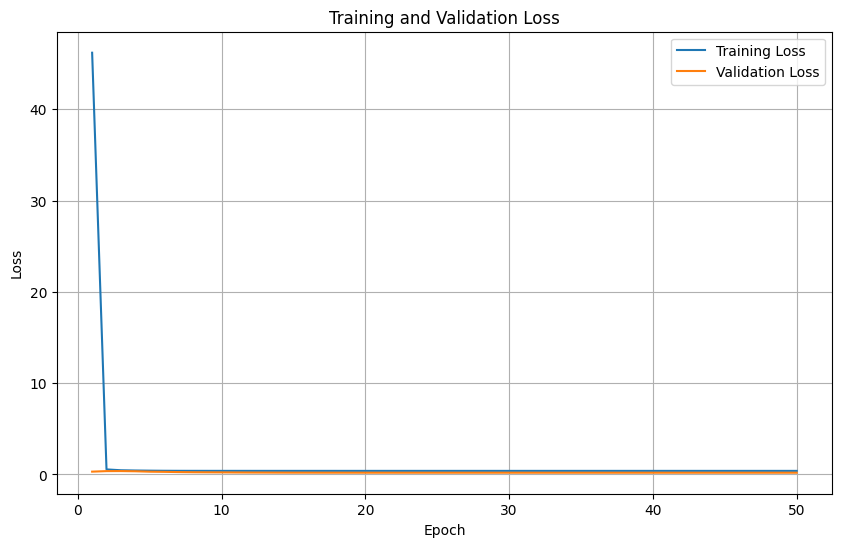

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
model.eval() # now set model to evaluation mode
preds_list, actuals_list = [], []
with torch.no_grad(): # no gradient evaluation
    for batch in tqdm(val_loader, desc="Making Predictions", leave=False):
        batch = batch.to(device)
        preds = model(batch.x, batch.hyperedge_index, batch.hyperedge_attr)
        preds_list.append(preds.cpu()) # store preds
        actuals_list.append(batch.y.cpu()) # store actual values

In [49]:
preds = torch.cat(preds_list, dim=0)
actuals = torch.cat(actuals_list, dim=0)

In [50]:
# kick out zero values
mask = actuals.abs().sum(dim=1) > 0  # mask for non-zero rows
preds = preds[mask].numpy()  # Apply mask  like we all do in life
actuals = actuals[mask].numpy()

In [51]:
mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))

# mape with proection from division by 0 courtesy of gpt
mape = np.mean(np.abs((actuals - preds) / np.clip(np.abs(actuals), 1e-10, None))) * 100

In [52]:
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 0.5306
MAPE: 54.46%


In [39]:
pred_df = pd.DataFrame(preds, columns=["Open", "High", "Low", "Close", "Volume"])
actual_df = pd.DataFrame(actuals, columns=["Open", "High", "Low", "Close", "Volume"])

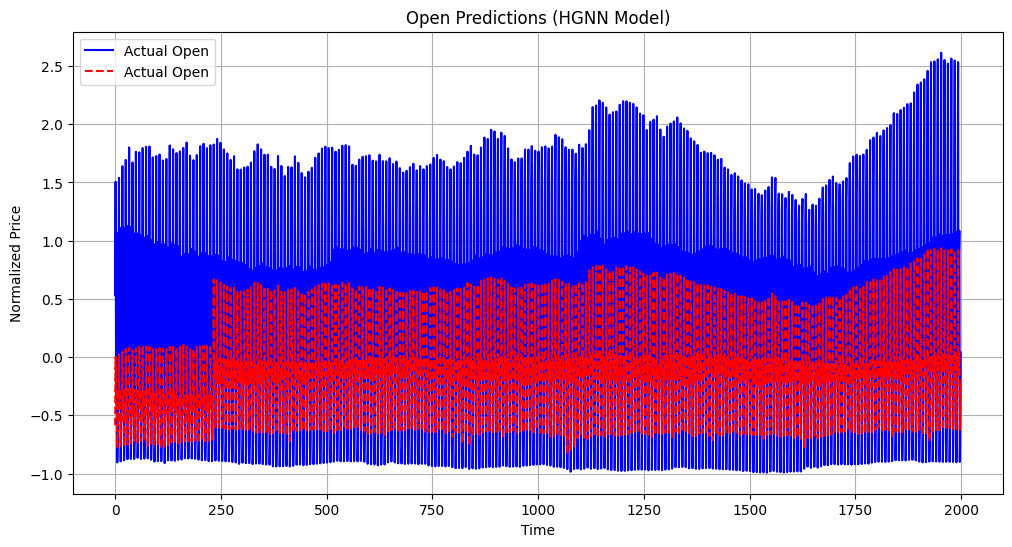

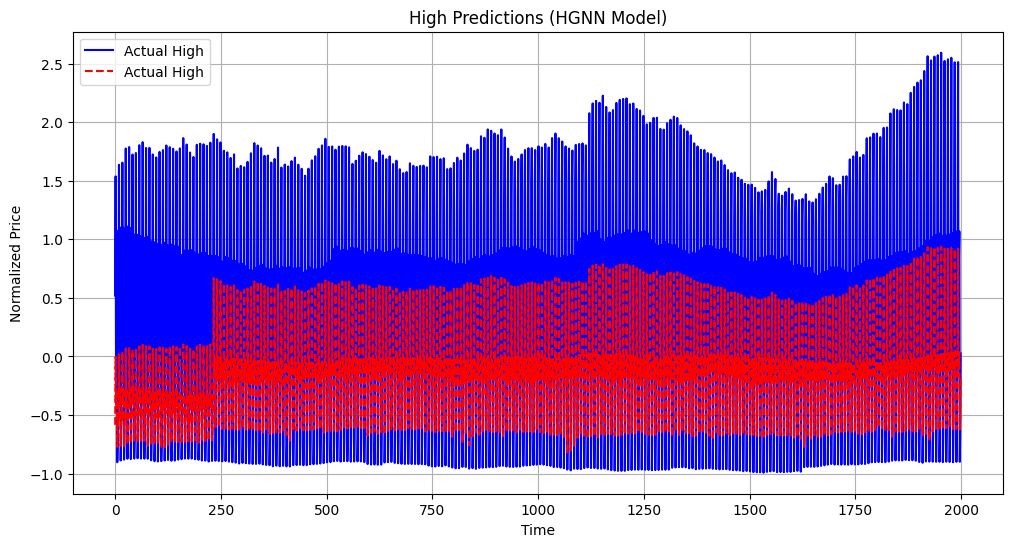

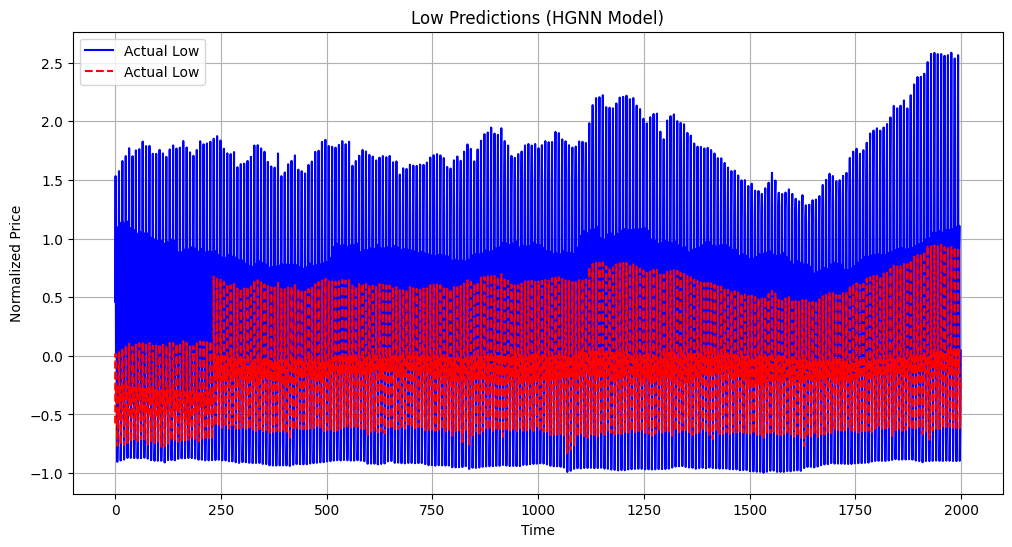

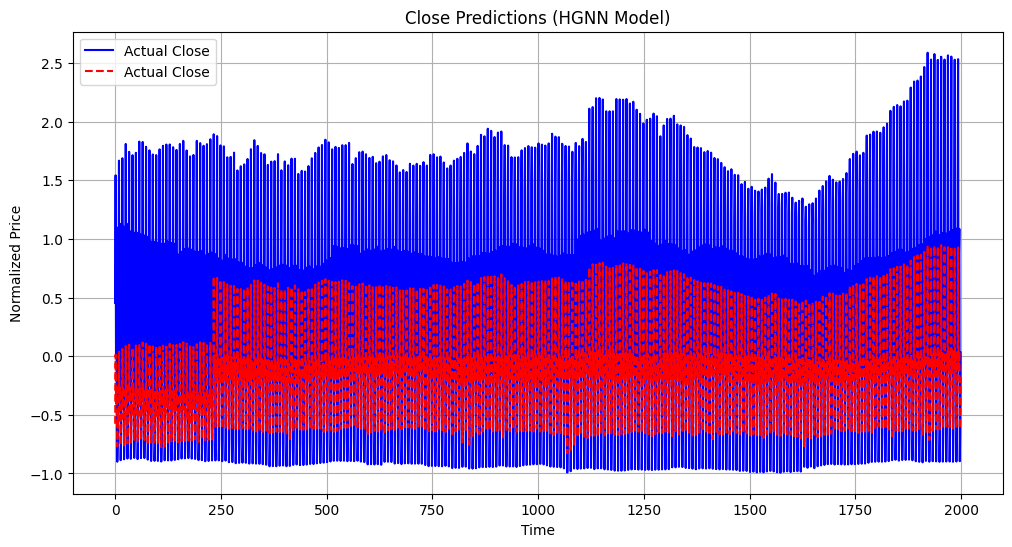

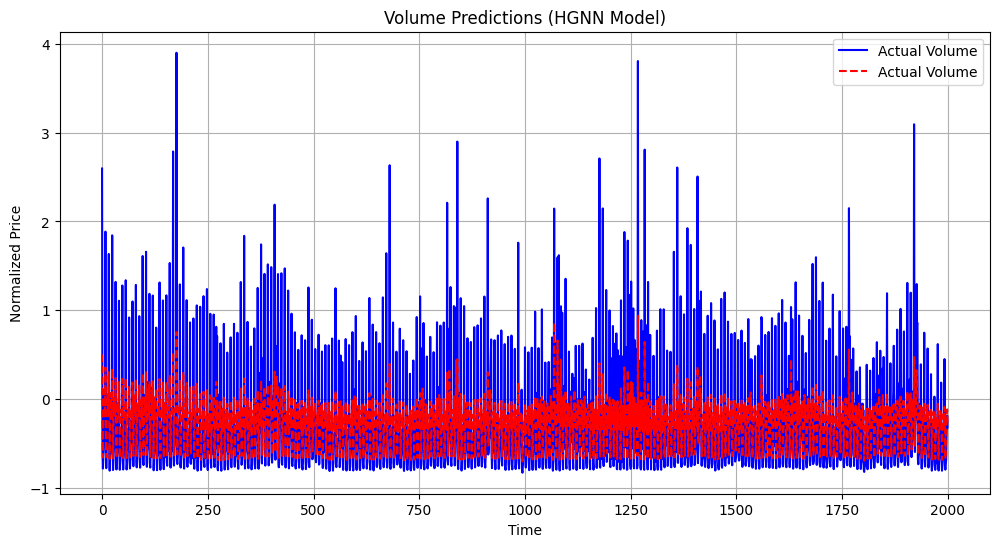

In [53]:
for column in pred_df.columns:
  plt.figure(figsize=(12, 6))
  plt.plot(actual_df[column], label= f"Actual {column}", color="blue")
  plt.plot(pred_df[column], label= f"Actual {column}", color="red", linestyle="dashed")
  plt.legend()
  plt.title(f"{column} Predictions (HGNN Model)")
  plt.xlabel("Time")
  plt.ylabel("Normalized Price")
  plt.grid(True)
  plt.show()
